### RRT Star

In [1]:
import cv2,glob,os,time
import mediapy as media
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import shapely as sp
import matplotlib.pyplot as plt
from PIL import Image
from networkx.algorithms.traversal.depth_first_search import dfs_edges
from shapely import Polygon
from rrt import RapidlyExploringRandomTreesStarClass
from util import rot_mtx,is_point_feasible,is_point_to_point_connectable,TicTocClass
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("networkx version:[%s]"%(nx.__version__))
print ("shapely version:[%s]"%(sp.__version__))

networkx version:[3.0]
shapely version:[2.0.1]


### Instantiate RRT*

In [2]:
RRT = RapidlyExploringRandomTreesStarClass(
    name='RRT-Star-2D',point_min=np.array([-1,-1]),point_max=np.array([+1,+1]),
    goal_select_rate=0.05,steer_len_max=0.1,search_radius=0.2,norm_ord=2,
    n_node_max=2000,TERMINATE_WHEN_GOAL_REACHED=False,SPEED_UP=True)
print ("[%s] instantiated."%(RRT.name))

[RRT-Star-2D] instantiated.


### Set obstacles

In [3]:
# Set obstacles (fixed)
RANDOM_OBSTACLES = True
if RANDOM_OBSTACLES:
    np.random.seed(seed=0)
    width,height,n_obs = 0.1,1.0,8
    box = np.array([[-width/2,-height/2],[width/2,-height/2],
                    [width/2,height/2],[-width/2,height/2]])
    obs_list = []
    for _ in range(n_obs):
        box_translate = box@rot_mtx(360*np.random.rand()) + (-1+2*np.random.rand(1,2))
        obs_list.append(Polygon(box_translate))
else:
    obs_list = []
    obs_list.append(Polygon([(0.25,0.5),(0.25,-0.5),(0.5,-0.5),(0.5,0.5)]))
    obs_list.append(Polygon([(0.5,0.5),(-0.5,0.5),(-0.5,0.25),(0.5,0.25)]))
    obs_list.append(Polygon([(-0.5,0.5),(-0.5,-0.5),(-0.25,-0.5),(-0.25,0.5)]))
    obs_list.append(Polygon([(0.25,-0.5),(1.0,-0.5),(1.0,-0.25),(0.25,-0.25)]))
print ("Ready.")

Ready.


### Remove existing images

In [4]:
png_paths = sorted(glob.glob('../temp/rrt_star_*.png'))
for png_path in png_paths:
    # print ("[%s] removed."%(png_path))
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))

[0] images removed.


### Loop

In [5]:
point_root,point_goal=np.array([0.75,-0.75]),np.array([0.7,0.8])
RRT.init_rrt_star(point_root=point_root,point_goal=point_goal)
TT,TT_total = TicTocClass(print_every=100),TicTocClass()
# TT_total.tic()
while True:
    # Number of nodes
    n_node = RRT.get_n_node()
    if n_node > RRT.n_node_max: break
    
    # Randomly sample a point
    TT.tic()
    while True:
        if np.random.rand() <= RRT.goal_select_rate: point_sample = RRT.point_goal 
        else: point_sample = RRT.sample_point() # random sampling
        if is_point_feasible(point_sample,obs_list): break
    TT.toc(str='[%d] sample'%(n_node),cnt=n_node)

    # Get the nearest node ('node_nearest') to 'point_sample' from the tree
    TT.tic()
    node_nearest = RRT.get_node_nearest(point_sample)
    TT.toc(str='[%d] nearest'%(n_node),cnt=n_node)
    
    # Steering towards 'point_sample' to get 'point_new'
    TT.tic()
    point_new,cost_new = RRT.steer(node_nearest,point_sample)
    TT.toc(str='[%d] steer'%(n_node),cnt=n_node)
    if point_new is None: continue # if the steering point is feasible

    # Rewiring
    if is_point_feasible(point_new,obs_list) \
        and is_point_to_point_connectable(RRT.get_node_point(node_nearest),point_new,obs_list):
        TT.tic()
        
        # Assign 'node_min' and initialize 'cost_min' with 'cost_new'
        node_min = node_nearest.copy()
        cost_min = cost_new
        
        # Select a set of nodes near 'point_new' => 'nodes_near'
        nodes_near = RRT.get_nodes_near(point_new)
        
        # For all 'node_near' find 'node_min'
        for node_near in nodes_near:
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            if is_point_to_point_connectable(point_near,point_new,obs_list):
                cost_prime = cost_near + RRT.get_dist(point_near,point_new)
                if cost_prime < cost_min:
                    cost_min = cost_near + RRT.get_dist(point_near,point_new)
                    node_min = node_near
                    
        # Add 'node_new' and connect it with 'node_min'
        node_new = RRT.add_node(point=point_new,cost=cost_min,node_parent=node_min)
        
        # New node information for rewiring
        point_new,cost_new = RRT.get_node_point_and_cost(node_new)
        
        # Rewire
        for node_near in nodes_near:
            if node_near == 0: continue
            if RRT.get_node_parent(node_near) == node_new: continue
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            cost_check = cost_new+RRT.get_dist(point_near,point_new)
            if (cost_check < cost_near) and \
                is_point_to_point_connectable(point_near,point_new,obs_list):
                RRT.replace_node_parent(node=node_near,node_parent_new=node_new)
        TT.toc(str='[%d] rewire'%(n_node),cnt=n_node)

        # Re-update cost of all nodes
        TT.tic()
        if RRT.SPEED_UP: node_source = node_min
        else: node_source = 0
        RRT.update_nodes_cost(node_source=node_source,VERBOSE=False)
        TT.toc(str='[%d] update cost'%(n_node),cnt=n_node)

    # Save image 
    if (RRT.get_n_node() % (RRT.n_node_max//200)) == 0:
        cost_goal = RRT.get_cost_goal()
        titlestr = '[%d] %s (cost_goal:[%.2f])'%(RRT.get_n_node(),RRT.name,cost_goal)
        png_path = '../temp/rrt_star_%05d.png'%(RRT.get_n_node())
        RRT.plot_tree_custom(
            figsize=(5,4),
            xlim=(RRT.point_min[0],RRT.point_max[0]),
            ylim=(RRT.point_min[1],RRT.point_max[1]),
            nodems=3,nodemec='k',nodemfc='w',nodemew=1/2,
            edgergba=[0,0,0,0.2],edgelw=1/2,
            startrgb=[1,0,0],startms=8,startmew=2,startfs=10,
            startbbalpha=0.7,start_xoffset=0.1,
            goalrgb=[0,0,1],goalms=8,goalmew=2,goalfs=10,
            goalbbalpha=0.7,goal_xoffset=0.1,
            pathrgba=[1,0,1,0.5],pathlw=5,pathtextfs=8,
            obs_list=obs_list,obsrgba=None,obsec='k',
            textfs=8,titlestr=titlestr,titlefs=10,
            PLOT_PATH_TEXT=False,PLOT_FULL_TEXT=False,
            SAVE_PNG=True,png_path=png_path,VERBOSE=False)
        
    # Plot image
    DEBUG_PLOT = False
    if ((RRT.get_n_node() % (RRT.n_node_max//5)) == 0) and DEBUG_PLOT:
        cost_goal = RRT.get_cost_goal()
        titlestr = '[%d] %s (cost_goal:[%.2f])'%(RRT.get_n_node(),RRT.name,cost_goal)
        RRT.plot_tree_custom(
            figsize=(5,4),
            xlim=(RRT.point_min[0],RRT.point_max[0]),
            ylim=(RRT.point_min[1],RRT.point_max[1]),
            nodems=3,nodemec='k',nodemfc='w',nodemew=1/2,
            edgergba=[0,0,0,0.2],edgelw=1/2,
            startrgb=[1,0,0],startms=8,startmew=2,startfs=10,
            startbbalpha=0.7,start_xoffset=0.1,
            goalrgb=[0,0,1],goalms=8,goalmew=2,goalfs=10,
            goalbbalpha=0.7,goal_xoffset=0.1,
            pathrgba=[1,0,1,0.5],pathlw=5,pathtextfs=8,
            obs_list=obs_list,obsrgba=None,obsec='k',
            textfs=8,titlestr=titlestr,titlefs=10,
            PLOT_PATH_TEXT=False,PLOT_FULL_TEXT=False,
            SAVE_PNG=False,VERBOSE=False)

    # Terminate condition
    dist_to_goal = RRT.get_dist_to_goal()
    if (dist_to_goal < 1e-6) and RRT.TERMINATE_WHEN_GOAL_REACHED:
        print ("Goad reached. n_node:[%d] dist_to_goal:[%.4f]"%
               (RRT.get_n_node(),dist_to_goal))
        break
# TT_total.toc(str='RRT* finished. #node:[%d]'%(RRT.get_n_node()))
print ("Done.")

[100] sample Elapsed time:[0.06]ms
[100] nearest Elapsed time:[0.06]ms
[100] steer Elapsed time:[0.04]ms
[100] rewire Elapsed time:[0.16]ms
[100] update cost Elapsed time:[0.03]ms
[200] sample Elapsed time:[0.07]ms
[200] nearest Elapsed time:[0.04]ms
[200] steer Elapsed time:[0.03]ms
[200] rewire Elapsed time:[0.36]ms
[200] update cost Elapsed time:[0.86]ms
[300] sample Elapsed time:[0.08]ms
[300] nearest Elapsed time:[0.17]ms
[300] steer Elapsed time:[0.02]ms
[300] rewire Elapsed time:[0.30]ms
[300] update cost Elapsed time:[1.19]ms
[400] sample Elapsed time:[0.05]ms
[400] nearest Elapsed time:[0.16]ms
[400] steer Elapsed time:[0.02]ms
[400] rewire Elapsed time:[0.31]ms
[400] update cost Elapsed time:[0.02]ms
[500] sample Elapsed time:[0.10]ms
[500] nearest Elapsed time:[0.02]ms
[500] steer Elapsed time:[0.02]ms
[500] rewire Elapsed time:[0.60]ms
[500] update cost Elapsed time:[0.02]ms
[600] sample Elapsed time:[0.06]ms
[600] nearest Elapsed time:[0.06]ms
[600] steer Elapsed time:[0.0

### Without `SPEED_UP`
```
cost:1.64
[2000] sample Elapsed time:[0.08]ms
[2000] nearest Elapsed time:[3.95]ms
[2000] steer Elapsed time:[0.02]ms
[2000] rewire Elapsed time:[4.57]ms
[2000] update cost Elapsed time:[7.46]ms
RRT* finished. #node:[2001] Elapsed time:[40.98]s
```
### With `SPEED_UP`
```
cost: 1.64
[2000] sample Elapsed time:[0.08]ms
[2000] nearest Elapsed time:[0.20]ms
[2000] steer Elapsed time:[0.02]ms
[2000] rewire Elapsed time:[1.18]ms
[2000] update cost Elapsed time:[0.03]ms
RRT* finished. #node:[2001] Elapsed time:[22.56]s
```

### To Video

In [ ]:
png_paths = sorted(glob.glob('../temp/rrt_star_*.png'))
frames = []
for png_path in png_paths:
    img_bgr = cv2.imread(png_path)
    img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    frames.append(img_rgb)
media.show_video(frames, fps=30)

### Remove images

In [7]:
png_paths = sorted(glob.glob('../temp/rrt_star_*.png'))
for png_path in png_paths:
    # print ("[%s] removed."%(png_path))
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))

[200] images removed.


### Get path to goal

In [8]:
path_to_goal,path_node_list = RRT.get_path_to_goal()
for node_idx,node in enumerate(path_node_list):
    print ("[%d/%d] node:[%d] point:%s cost:[%.2f]"%
           (node_idx,len(path_node_list),node,RRT.get_node_point(node),
            RRT.get_node_cost(node)))

[0/13] node:[0] point:[ 0.75 -0.75] cost:[0.00]
[1/13] node:[522] point:[ 0.83 -0.6 ] cost:[0.17]
[2/13] node:[1415] point:[ 0.89 -0.48] cost:[0.30]
[3/13] node:[1449] point:[ 0.94 -0.4 ] cost:[0.40]
[4/13] node:[1640] point:[ 0.96 -0.2 ] cost:[0.60]
[5/13] node:[800] point:[ 0.89 -0.07] cost:[0.75]
[6/13] node:[1929] point:[0.86 0.01] cost:[0.84]
[7/13] node:[1659] point:[0.83 0.19] cost:[1.02]
[8/13] node:[1960] point:[0.83 0.23] cost:[1.06]
[9/13] node:[1741] point:[0.78 0.42] cost:[1.26]
[10/13] node:[1147] point:[0.73 0.6 ] cost:[1.44]
[11/13] node:[1810] point:[0.72 0.74] cost:[1.58]
[12/13] node:[376] point:[0.7 0.8] cost:[1.64]


### Plot

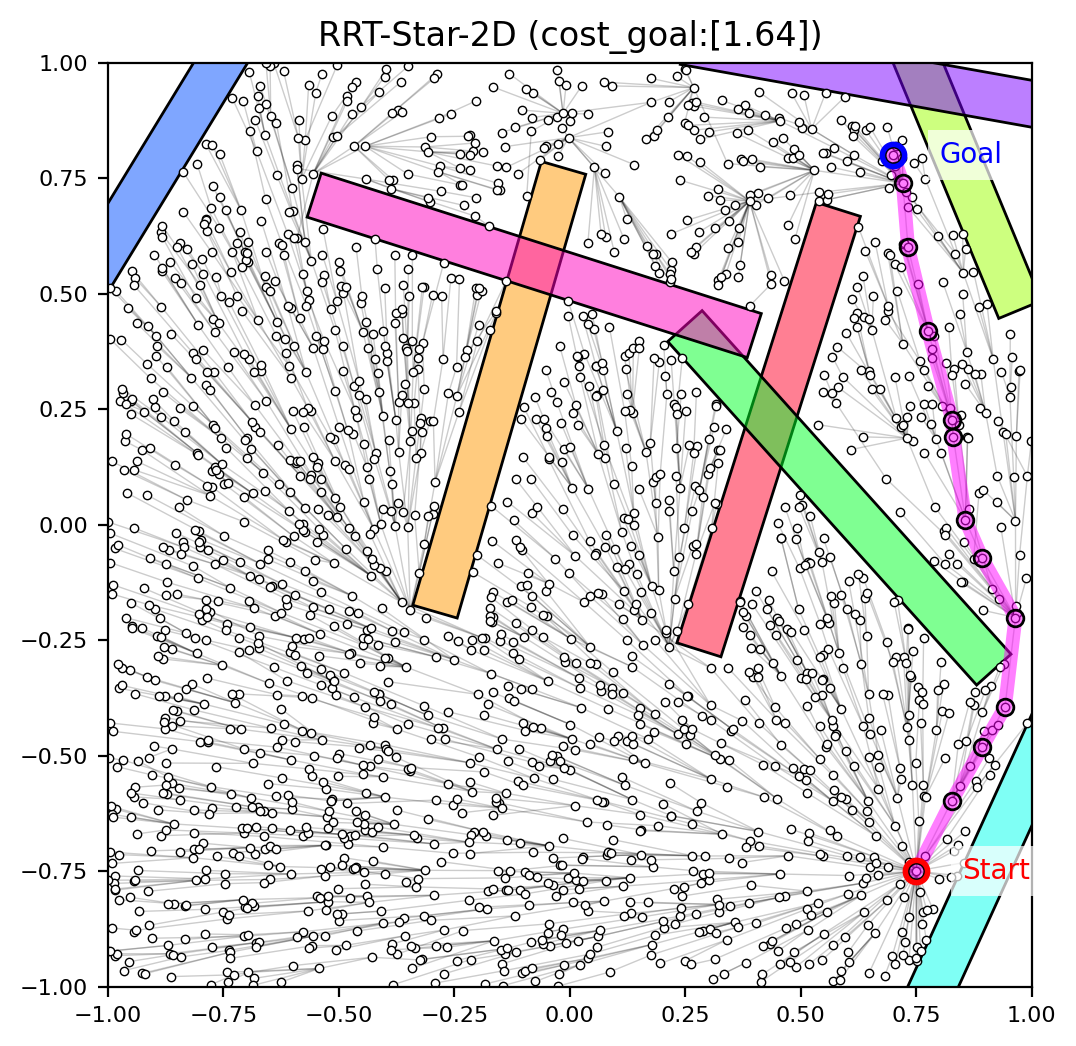

In [9]:
titlestr = '%s (cost_goal:[%.2f])'%(RRT.name,cost_goal)
RRT.plot_tree_custom(
    figsize=(6,6),
    xlim=(RRT.point_min[0],RRT.point_max[0]),
    ylim=(RRT.point_min[1],RRT.point_max[1]),
    nodems=3,nodemec='k',nodemfc='w',nodemew=1/2,
    edgergba=[0,0,0,0.2],edgelw=1/2,
    startrgb=[1,0,0],startms=8,startmew=2,startfs=10,startbbalpha=0.7,start_xoffset=0.1,
    goalrgb=[0,0,1],goalms=8,goalmew=2,goalfs=10,goalbbalpha=0.7,goal_xoffset=0.1,
    pathrgba=[1,0,1,0.5],pathlw=5,pathtextfs=10,
    obs_list=obs_list,obsrgba=None,obsec='k',
    textfs=8,titlestr=titlestr,titlefs=12,
    PLOT_PATH_TEXT=False,PLOT_FULL_TEXT=False)